In [348]:
%matplotlib inline
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [474]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        
        self.i2o = nn.Linear(input_size + hidden_size, hidden_size)
        self.o2o = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.h2h(F.relu(self.i2h(combined)))
        output = self.o2o(F.relu(self.i2o(combined)))
            
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
def makeData(npoints = 500, f = None):
    
    if f is None:
        f = lambda x: x*x + 10
    
    x = np.linspace(0, 10*np.pi, npoints)
    
    y = np.array(list(map(f, x)))
    
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    
    return x, y

In [60]:
def loadData(filename, npoints = 100):
    
    df = pd.read_json(filename, orient = 'values')
    
    y = torch.Tensor(df.values)[:npoints]
    
    return y

In [49]:
def sequence_train_test_split(sequence, test = 0.2):
    
    n = len(sequence)
    
    indices = np.arange(n)
    
    train_split = 1 - test
    ntrain = int(n * train_split)
    
    train_indices, test_indices = indices[:ntrain], indices[ntrain:]
    
    train_sequence = sequence[train_indices]
    test_sequence = sequence[test_indices]
    
    train_input = train_sequence[:-1].unsqueeze(2)
    train_target = train_sequence[1:]
    
    test_input = test_sequence[:-1].unsqueeze(2)
    test_target = test_sequence[1:]
    
    return train_input, test_input, train_target, test_target

In [375]:
def train(rnn, train_input, train_target, lr = 0.001, epochs = 1000, teacher_forcing_ratio = 0.5, plot = True):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(rnn.parameters(), lr = lr)
    
    try:
        for epoch in range(epochs):

            hidden = rnn.initHidden()
            
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            
            loss = 0
            outputs = []
            
            if use_teacher_forcing:
            
                for i, input in enumerate(train_input):
                    output, hidden = rnn(input, hidden)
                    outputs.append(output)
                    
                    l = criterion(output, train_target[i])
                    loss += l
            
            else:
                
                output = train_input[0]
                
                for i in range(len(train_target)):
                    output, hidden = rnn(output, hidden)
                    outputs.append(output)
                    
                    l = criterion(output, train_target[i])
                    loss += l
                    
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 25 == 0:
                print('epoch {}, loss {}, teacher forcing: {}'.format(epoch, loss, use_teacher_forcing))
            
            
            
    except KeyboardInterrupt:
        pass
    
    if plot:
        
        hidden = rnn.initHidden()
        outputs = []
        
        for i, input in enumerate(train_input):
            output, hidden = rnn(input, hidden)
            outputs.append(output)
        
        pred_target = torch.Tensor(outputs).view(-1,1)
        
        with torch.no_grad():
            t = np.arange(train_input.size(0))

            plt.plot(t, pred_target.detach().numpy(), color = 'red', linewidth = 2)
            plt.plot(t, train_target.detach().numpy(), color = 'blue', linewidth = 1)
            
    return rnn

In [422]:
def predict(rnn, train_input, train_target, test_input, test_target, future = 50, plot = True):
    
    hidden = rnn.initHidden()

    training_outputs = []
    for input in train_input:
        output, hidden = rnn(input, hidden)
        training_outputs.append(output)
        
    pred_train_target = torch.Tensor(training_outputs).view(-1,1)
      
    testing_outputs = []   
    for i, input in enumerate(test_input):
        output, hidden = rnn(input, hidden)
        testing_outputs.append(output)
        
    pred_test_target = torch.Tensor(testing_outputs).view(-1,1)
    
    future_targets = []
    for _ in range(future):
        output, hidden = rnn(output, hidden)
        future_targets.append(output)
      
    pred_future_target = torch.Tensor(future_targets).view(-1,1)
        
    
    if plot:
        
        with torch.no_grad():
            t1 = np.arange(pred_train_target.size(0))
            t2 = np.arange(len(t1), len(t1) + pred_test_target.size(0))
            t3 = np.arange(len(t1) + len(t2), len(t1) + len(t2) + pred_future_target.size(0))
            
            s = 50
            plt.plot(t1[s:], pred_train_target.numpy()[s:], color = 'red', linewidth = 2, label = 'Train Prediction')
            plt.plot(t1[s:], train_target.numpy()[s:], color = 'blue', linewidth = 1, label = 'Train True')
            
            plt.plot(t2, pred_test_target.numpy(), color = 'red', linewidth = 2, linestyle = '--', label = 'Test Prediction')
            plt.plot(t2, test_target.numpy(), color = 'blue', linewidth = 1, linestyle = '--', label = 'Test True')
            
            plt.plot(t3, pred_future_target.numpy(), color = 'green', linewidth = 2, label = 'Future Prediction')
            
            plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [475]:
n_input = 1
n_hidden = 128
n_output = 1
rnn = RNN(n_input, n_hidden, n_output)

In [476]:
npoints = 100
f = lambda x: np.sin(x)
_, y = makeData(npoints=npoints, f = f)
y = loadData('ml_input_foo.json', npoints = npoints)

In [477]:
print(y.shape)

torch.Size([100, 1])


In [478]:
train_input, test_input, train_target, test_target= sequence_train_test_split(y)

In [479]:
print(train_input.size())
print(train_target.size())

torch.Size([79, 1, 1])
torch.Size([79, 1])


In [480]:
print(test_input.size())
print(test_target.size())

torch.Size([19, 1, 1])
torch.Size([19, 1])


epoch 0, loss 270490.0, teacher forcing: True
epoch 25, loss 158942.875, teacher forcing: True
epoch 50, loss 15933.119140625, teacher forcing: True
epoch 75, loss 11984.0107421875, teacher forcing: True
epoch 100, loss 7429.0458984375, teacher forcing: True
epoch 125, loss 224774.609375, teacher forcing: False
epoch 150, loss 19493.3515625, teacher forcing: True
epoch 175, loss 158509.703125, teacher forcing: True
epoch 200, loss 171391.140625, teacher forcing: True
epoch 225, loss 252877.28125, teacher forcing: False
epoch 250, loss 40274.87890625, teacher forcing: True
epoch 275, loss 26591.029296875, teacher forcing: True
epoch 300, loss 92522.5078125, teacher forcing: True
epoch 325, loss 127665.9375, teacher forcing: True
epoch 350, loss 120319.96875, teacher forcing: True
epoch 375, loss 246027.71875, teacher forcing: False
epoch 400, loss 243861.375, teacher forcing: False
epoch 425, loss 77791.6796875, teacher forcing: True
epoch 450, loss 49313.484375, teacher forcing: True
e

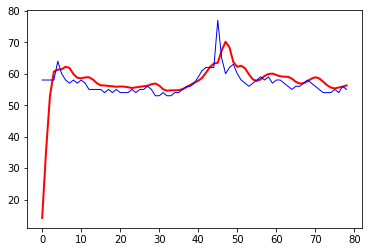

In [481]:
rnn = train(rnn, train_input, train_target, lr = 0.0003, epochs=1000, teacher_forcing_ratio=.8)

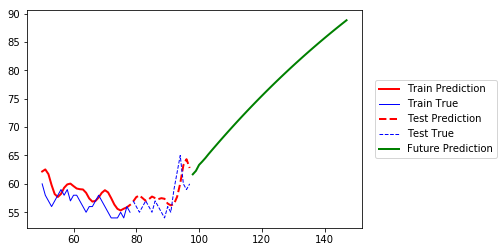

In [482]:
predict(rnn, train_input, train_target, test_input, test_target, future = 50)